In [1]:
from lib.imports import *
from lib.functions import *
from lib.utils import *
from lib.modules import *
from ipynb.fs.defs.losses import *

In [2]:
cuda_idx = None
config = Config('gnn_stress-Copy100.json')
loss_fns = {
    StressLoss(): 0.9,
    EdgeLengthVarianceLoss(): 0.1
}
model_params = {
    "num_blocks": 9
}
ctrler_params = {
    "tau": 0.95,
    "beta": 1,
    "exploit_rate": 0.3,
    "warmup": 2
}

In [22]:
ckpt_folder = f"./checkpoints/{config.name}"
tb_folder = f"./tensorboards/{config.name}"
vis_folder = f'./visualizations/{config.name}_{config.test.name}'
log_file = f"./logs/{config.name}.log"

In [6]:
device = f'cuda:{cuda_idx}' if cuda_idx is not None and torch.cuda.is_available() else 'cpu'
# nvidia_smi.nvmlInit()
# cuda = nvidia_smi.nvmlDeviceGetHandleByIndex(cuda_idx) if cuda_idx is not None else None
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [7]:
G_list, data_list = load_processed_data(G_list_file='G_list_1.pickle', 
                                        data_list_file='data_list_1.pickle',
                                        index_file='data_index_1.txt')
train_loader = DataLoader(data_list[:10000], batch_size=config.batchsize, shuffle=True)
val_loader = DataLoader(data_list[11000:], batch_size=config.batchsize, shuffle=False)

In [23]:
state_dict = torch.load(f'{ckpt_folder}/epoch_{config.test.epoch}.pt', map_location=torch.device(device))
model = Model(**model_params).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [24]:

def predict(model, batch, criterion, **model_params):
    if type(criterion) is not CompositeLoss:
        criterion = CompositeLoss([criterion])
    batch = preprocess_batch(model, batch)
    output = model(batch, **model_params,output_hiddenn=True)
    pred = output[0] if output is tuple else output
    loss, components = criterion(pred, batch, return_components=True)
    return output, loss, components

def validate(model, criterion, data_loader, callback=None):
    if callback is None:
        callback = lambda *_, **__: None
    with torch.no_grad():
        model.eval()
        loss_all, components_all = [], []
        for batch in data_loader:
            output, loss, components = predict(model, batch, criterion)
            loss_all.append(loss.item())
            components_all.append([comp.item() for comp in components])
            callback(output=output, loss=loss, components=components)
    return np.mean(loss_all), np.mean(components_all, axis=0)


In [68]:
model.eval()
output_1 = model(data_list[0], output_hidden=False,with_initial_pos=True)

In [69]:
output_2 = model(data_list[0], output_hidden=False,with_initial_pos=True)

In [71]:
output_1

tensor([[-1.0373, -3.2034],
        [ 1.9917,  1.5287],
        [-2.6322, -1.8388],
        [-0.8236, -0.4955],
        [ 1.1162, -2.3033],
        [-0.9821, -4.4384],
        [-2.5583, -3.3913],
        [-3.6716,  0.3597],
        [-0.3345, -2.1883],
        [ 0.3239, -0.9479],
        [-0.2869,  0.9307],
        [ 1.7102, -0.7593],
        [ 1.3040,  0.1989],
        [ 1.3018,  0.8869],
        [-2.4144, -0.4580],
        [-1.1585, -1.5856]], grad_fn=<AddBackward0>)

In [72]:
output_2

tensor([[-1.0373, -3.2034],
        [ 1.9917,  1.5287],
        [-2.6322, -1.8388],
        [-0.8236, -0.4955],
        [ 1.1162, -2.3033],
        [-0.9821, -4.4384],
        [-2.5583, -3.3913],
        [-3.6716,  0.3597],
        [-0.3345, -2.1883],
        [ 0.3239, -0.9479],
        [-0.2869,  0.9307],
        [ 1.7102, -0.7593],
        [ 1.3040,  0.1989],
        [ 1.3018,  0.8869],
        [-2.4144, -0.4580],
        [-1.1585, -1.5856]], grad_fn=<AddBackward0>)

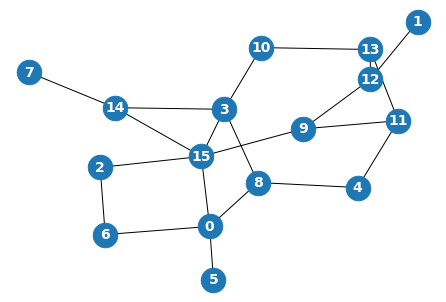

In [66]:
graph_vis(G_list[0], output_2[11], node_size=600, with_labels=True, font_color="white", font_weight="bold", font_size=14)

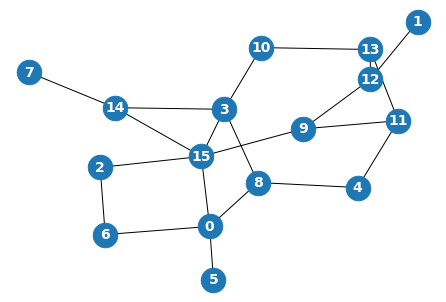

In [67]:
graph_vis(G_list[0], output_1[11], node_size=600, with_labels=True, font_color="white", font_weight="bold", font_size=14)